# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [1]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [2]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

## Exploratory Analysis
To try better understand the unitary matrix.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Inspecting the matrix structure!

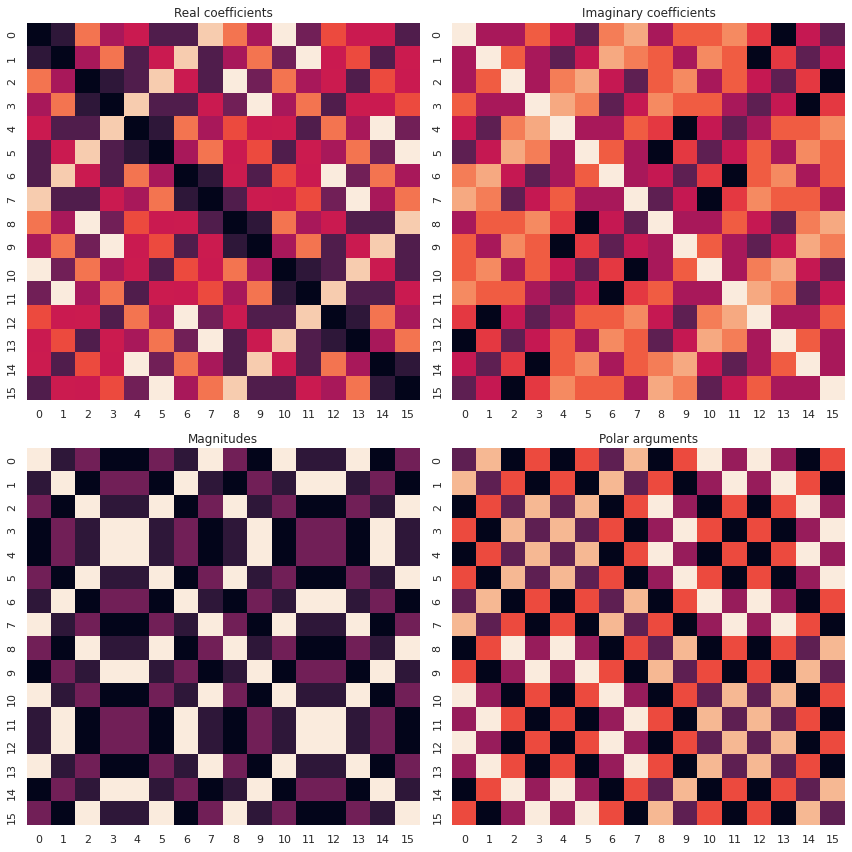

In [4]:
A = np.matrix(U)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(A.real, cbar=False)
plt.title('Real coefficients')

plt.subplot(2, 2, 2)
sns.heatmap(A.imag, cbar=False)
plt.title('Imaginary coefficients')

plt.subplot(2, 2, 3)
sns.heatmap(np.square(np.abs(A)), cbar=False)
plt.title('Magnitudes')

plt.subplot(2, 2, 4)
sns.heatmap(np.arctan(A.real/A.imag), cbar=False)
plt.title('Polar arguments')

plt.tight_layout()
plt.show()

This seems to exhibit some symmetry, but without a clear decomposition. A hint from exercise 1 suggests a hadamard transform and we inspect the transformed operator.

In [5]:
H = np.matrix([
    [1, 1],
    [1, -1],
])/np.sqrt(2)

H2 = np.kron(H, H)
H4 = np.kron(H2, H2)

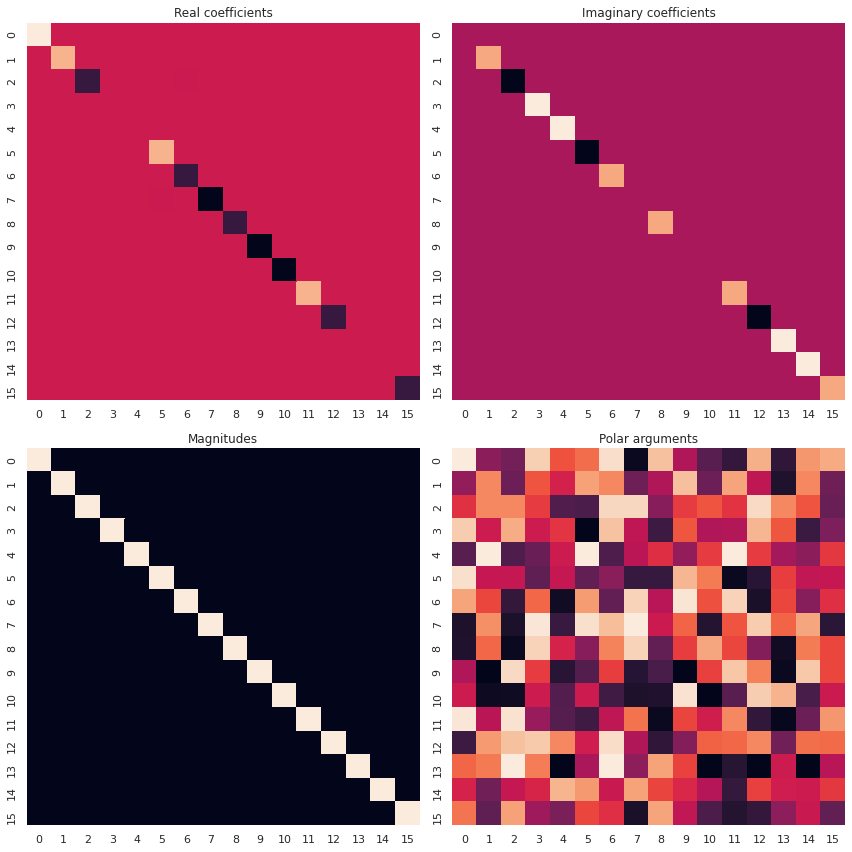

In [6]:
A = np.matrix(H4*U*H4)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(A.real, cbar=False)
plt.title('Real coefficients')

plt.subplot(2, 2, 2)
sns.heatmap(A.imag, cbar=False)
plt.title('Imaginary coefficients')

plt.subplot(2, 2, 3)
sns.heatmap(np.square(np.abs(A)), cbar=False)
plt.title('Magnitudes')

plt.subplot(2, 2, 4)
sns.heatmap(np.arctan(A.real/A.imag), cbar=False)
plt.title('Polar arguments')

plt.tight_layout()
plt.show()

The transformed operator seems to only contain diagonal entries and is a good candidate for transpilation! 

## Solution 1: Naive Solution
Attempt to add an isometry of the original U matrix to a circuit and transpile using the basis gates {u3,cx}.

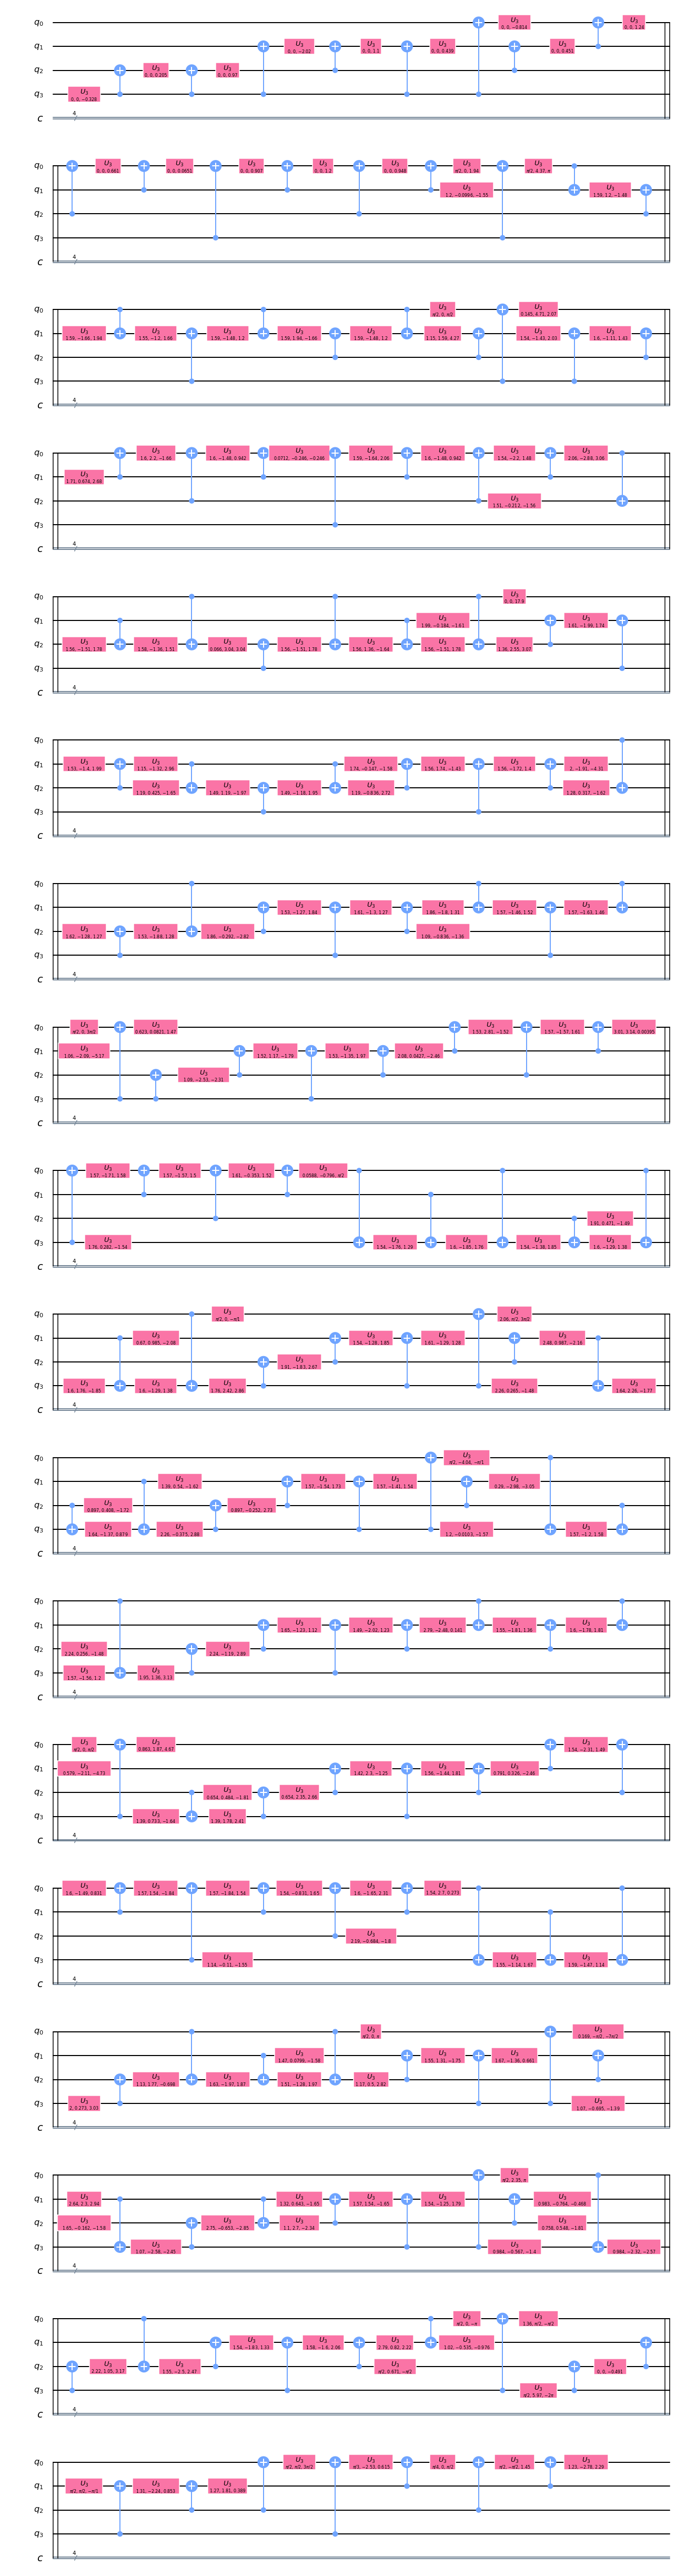

In [8]:
##### build your quantum circuit here
qc = QuantumCircuit(4, 4)

# apply operations to your quantum circuit here
from qiskit import transpile

qc.iso(U, [0, 1, 2, 3], [])

qc = transpile(
    circuits = qc,
    basis_gates = ['u3', 'cx'],
    optimization_level = 2, # As epsilon is rather large, a lower optimization level leads to a lower gate cost
)

qc.draw()

In [9]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 4.2634217757239e-14
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 1663

Something is not right with your circuit: the cost of the circuit is too high (above 1600)


## Solution 2: Hadamard Transform
Perform a hadamard transform on the operator to improve transpilation. The inverse hadamard transform can be implemented by a set of u3 gates and is relatively cheap to apply. Furthermore, it is likely that the compiler will simplify the circuit, hence, the transformation acts more like a hint for the transpiler.

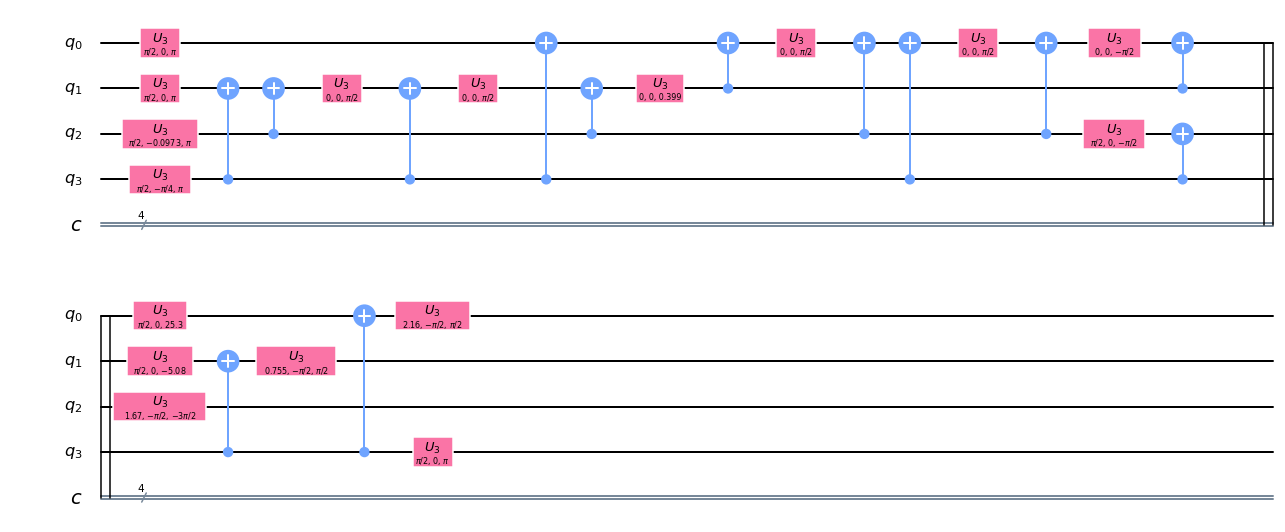

In [20]:
##### build your quantum circuit here
qc = QuantumCircuit(4, 4)

# apply operations to your quantum circuit here
from qiskit import transpile

qc.h([0,1,2,3])
qc.iso(H4*U*H4, [0, 1, 2, 3], [])
qc.h([0,1,2,3])

qc = transpile(
    circuits = qc,
    basis_gates = ['u3', 'cx'],
    optimization_level = 2, # As epsilon is rather large, a lower optimization level leads to a lower gate cost
)

qc.draw()

Indeed, this produces a ahallow circuit with minimal gate usage.

In [21]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 9.942226695819332e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 147

Great! Your circuit meets all the constrains.
Your score is 147. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


## Solution 3: Fine Tuning
In this solution, we note that the hadamard gate is implemented by a u3(pi/2, 0, pi) gate. The effect of varying these parameters on the transpiled circuit is investigated. However, this is likely to be uneffective as the score is still mainly bound by the transpilation's error tolerance being much lower than epsilon.

In [149]:
from may4_challenge.ex4 import check_and_score_circuit
from qiskit.extensions.standard.u3 import U3Gate
from qiskit import transpile

from tqdm.notebook import tqdm_notebook
import pandas as pd

tqdm_notebook.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
def param_circuit(theta, phi, lam):
    # New circuit
    qc = QuantumCircuit(4, 4)

    # "Hadamard" gate
    gate = U3Gate(theta, phi, lam)
    gate_inv = gate.inverse()
    
    # Construct equivalent matrix
    G = np.matrix(gate.to_matrix())
    G2 = np.kron(G, G)
    G4 = np.kron(G2, G2)

    # Apply transform
    qc.append(gate, [0], [])
    qc.append(gate, [1], [])
    qc.append(gate, [2], [])
    qc.append(gate, [3], [])
    qc.iso(G4.H*U*G4, [0, 1, 2, 3], [])
    qc.append(gate_inv, [0], [])
    qc.append(gate_inv, [1], [])
    qc.append(gate_inv, [2], [])
    qc.append(gate_inv, [3], [])
    
    return qc

def test_circuit(theta, phi, lam):
    # Get circuit
    qc = param_circuit(theta, phi, lam)

    # Transpile circuit
    qc = transpile(
        circuits = qc,
        basis_gates = ['u3', 'cx'],
        optimization_level = 3,
    )
    
    status, details = check_and_score_circuit(qc)
    return status, details.delta, details.complexity, details.score

We are interested in covering the entire parameter space of a u3 transformation across all qubits, of which the hadamard transform is a special case.

In [6]:
# Prepare parameters
deltas = np.linspace(0, 2*np.pi, 5)
params = pd.MultiIndex.from_product(
    iterables = [deltas, deltas, deltas], 
    names=['theta', 'phi', 'lam']
)

# Parameter grid
runs = pd.DataFrame(index=params).reset_index()

# Run testing
def track(f):
    best_score = [1600]
    def helper(x):
        status, delta, complexity, score = f(x)
        if (status is True) and (score < best_score[0]):
            best_score[0] = score
            print(f'best score: {best_score[0]}')
        return status, delta, complexity, score
    return helper

@track
def test_func(run):
    try:
        return test_circuit(np.pi/2 + run.theta, run.phi, np.pi +  run.lam)
    except:
        return False, None, None, None

runs['result'] = runs.progress_apply(test_func, axis=1)

# Unpack results
runs['status'] = runs.result.apply(lambda x: x[0])
runs['delta'] = runs.result.apply(lambda x: x[1])
runs['complexity'] = runs.result.apply(lambda x: x[2])
runs['score'] = runs.result.apply(lambda x: x[3])
runs = runs.drop(columns='result')

best score: 195
best score: 62



In [7]:
# Check best runs
best_runs = runs[runs.status & (runs.score == runs.score.min())]
best_runs

,theta,phi,lam,status,delta,complexity,score
12,0.0,3.141593,3.141593,True,1.027687e-14,62,62.0


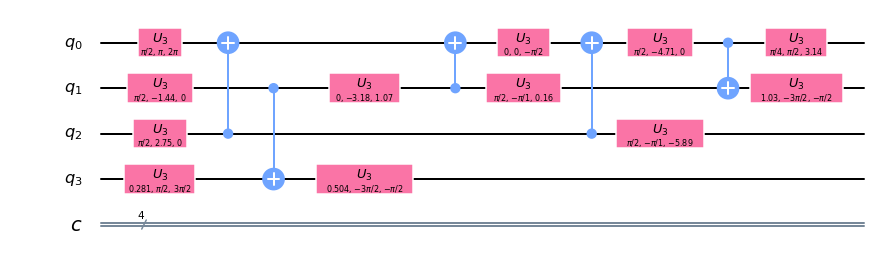

In [8]:
# Generate best circuit
best_params = np.array([np.pi/2, 0, np.pi]) + best_runs[params.names].values[0]
best_circuit = param_circuit(*best_params)

# Transpile circuit
qc = transpile(
    circuits = best_circuit,
    basis_gates = ['u3', 'cx'],
    optimization_level = 3,
)

# Inspect circuit
qc.draw()

In [9]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.0276869408878863e-14
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 62

Great! Your circuit meets all the constrains.
Your score is 62. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Surprisingly, this method produces significantly lower scores! We can try a local search to further optimize.

In [21]:
# Prepare parameters
deltas = np.linspace(-1e-10, 1e-10, 9)
params = pd.MultiIndex.from_product(
    iterables = [deltas, deltas, deltas], 
    names=['theta', 'phi', 'lam']
)

# Parameter grid
runs = pd.DataFrame(index=params).reset_index()

# Run testing
def track(f):
    best_score = [1600]
    def helper(x):
        status, delta, complexity, score = f(x)
        if (status is True) and (score < best_score[0]):
            best_score[0] = score
            print(f'best score: {best_score[0]}')
        return status, delta, complexity, score
    return helper

@track
def test_func(run):
    try:
        theta, phi, lam = best_params
        return test_circuit(theta + run.theta, phi + run.phi, lam + run.lam)
    except:
        return False, None, None, None

runs['result'] = runs.progress_apply(test_func, axis=1)

# Unpack results
runs['status'] = runs.result.apply(lambda x: x[0])
runs['delta'] = runs.result.apply(lambda x: x[1])
runs['complexity'] = runs.result.apply(lambda x: x[2])
runs['score'] = runs.result.apply(lambda x: x[3])
runs = runs.drop(columns='result')

/opt/conda/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/squ.py:122: RuntimeWarning: invalid value encountered in arccos
  b = 2 * np.arccos(np.abs(u00))


best score: 1264
best score: 834
best score: 125
best score: 124
best score: 105
best score: 73
best score: 62



The score does not improve and we attempt to inspect the local region.

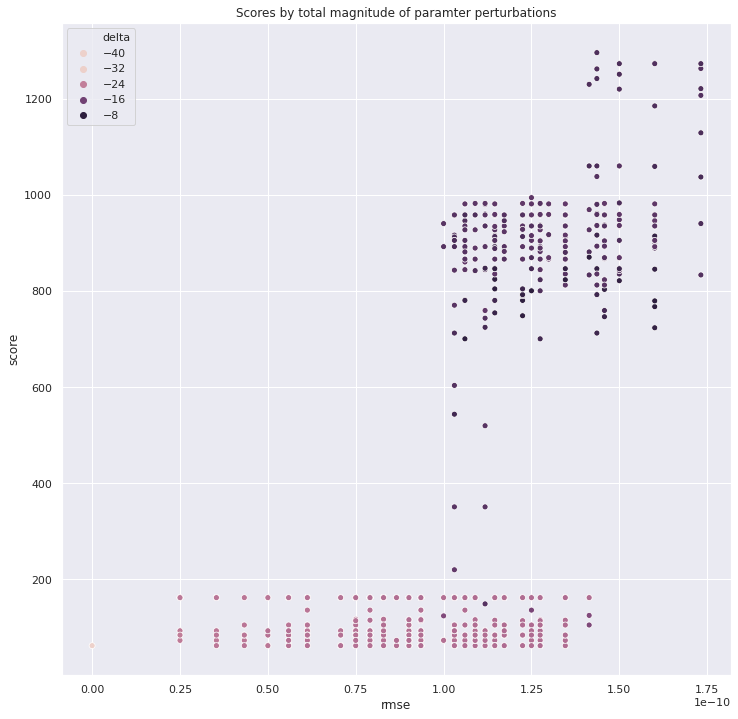

In [188]:
# RMSE of the perturbations to the best parameters
runs['rmse'] = np.sqrt(np.sum(np.square(runs[params.names]), axis=1))

plt.figure(figsize=(12, 12))
plt.title('Scores by total magnitude of paramter perturbations')
sns.scatterplot(runs.rmse, runs.score, hue=np.log(runs.delta))
plt.show()

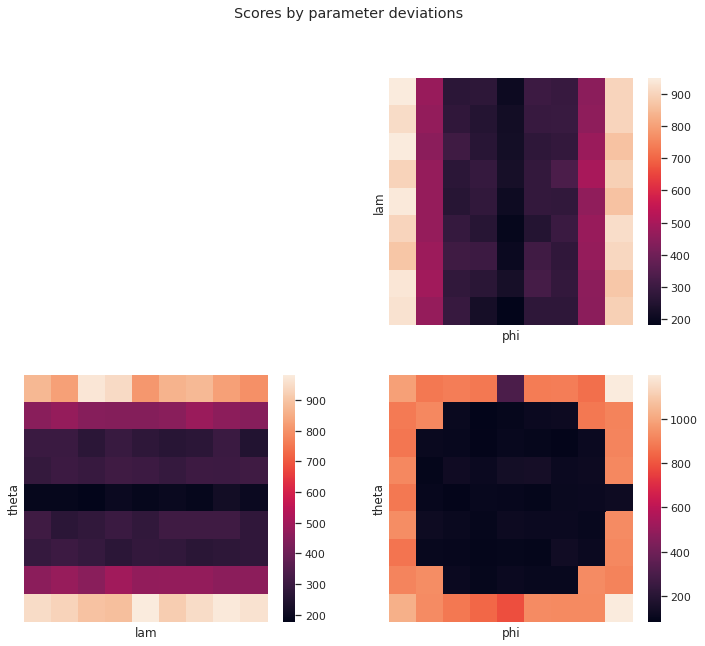

In [189]:
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Scores by parameter deviations')

plt.subplot(2, 2, 2)
sns.heatmap(runs.pivot_table('score', 'lam', 'phi'), xticklabels=[], yticklabels=[])

plt.subplot(2, 2, 3)
sns.heatmap(runs.pivot_table('score', 'theta', 'lam'), xticklabels=[], yticklabels=[])

plt.subplot(2, 2, 4)
sns.heatmap(runs.pivot_table('score', 'theta', 'phi'), xticklabels=[], yticklabels=[])

plt.show()

Interestingly, the score in this region seems most sensitive to the interactions between theta and phi.

## Solution 4: Heuristic Parameter Search
The current best solution is obtained with a grid search and it is natural to expect a heuristic search to be more promising. However, as the scoring function is not analytically differentiable, we are limited to using direct search. As the transpilation in each search iteration takes a considerable amount of time, this method might prove too inefficient to yield any results. 

In [6]:
from IPython.display import clear_output
import time

class ProgressTracker:
    """Custom buffered callback for scipy optimizers"""
    def __init__(self, n):
        self.buffer = []
        self.count = 0
        self.tic = time.time()
        self.n = n
        
    def __call__(self, x, *args, **kwargs):
        toc = time.time()
        self.count += 1
        self.buffer.append(f'[{self.count}] params: {x} ({toc-self.tic:.0f} seconds)')
        self.tic = toc
        
        clear_output(wait=True)
        print('\n'.join(self.buffer[-self.n:]))
        
def search_func(params):
    """Objective function to minimize"""
    try:
        _, _, complexity, _ = test_circuit(*params)
        return complexity
    except:
        return np.inf

Direct search algorithms do not seem effective. Possibly the scores in the local region are identical?

In [31]:
from scipy.optimize import minimize

search_results = minimize(
    fun = search_func,
    x0 = np.random.rand(3)*2*np.pi,
    method = 'Nelder-Mead',
    callback = ProgressTracker(n=5),
)

if search_results.success:
    print('Success!')
    print('Search params:', search_results.x)
    print('Score:', search_func(search_results.x))
else:
    print('Error:', search_results.message)

[8] params: [6.19273282 0.36566645 5.47890996] (11.805845737457275 seconds)
[9] params: [6.19273282 0.36566645 5.47890996] (11.817847490310669 seconds)
[10] params: [6.19273282 0.36566645 5.47890996] (11.806520462036133 seconds)
[11] params: [6.19273282 0.36566645 5.47890996] (11.770633459091187 seconds)
[12] params: [6.19273282 0.36566645 5.47890996] (11.885664939880371 seconds)
Success!
Search params: [6.19273282 0.36566645 5.47890996]
Score: 2446


In [16]:
from scipy.optimize import differential_evolution

search_results = differential_evolution(
    func = search_func,
    bounds = [(0, 2*np.pi), (0, 2*np.pi), (0, 2*np.pi)],
    popsize = 15,
    callback = lambda x, convergence: print(x, '( convergence =', convergence, ')'),
)

if search_results.success:
    print('Success!')
    print('Search params:', search_results.x)
    print('Score:', search_func(search_results.x))
else:
    print('Error:', search_results.message)

[5.33161471 2.54236185 2.23176363] ( convergence = inf )
Success!
Search params: [5.33161471 2.54236185 2.23176363]
Score: 2446


In [ ]:
from scipy.optimize import basinhopping

search_results = basinhopping(
    func = search_func,
    x0 = [np.pi/2, np.pi, 2*np.pi],
    T = 50,
    stepsize = 1e-10,
    niter = 10,
    callback = lambda x, f, accept: print(x, ', score =', f, '( accept =', accept, ')'),
)

if search_results.success:
    print('Success!')
    print('Search params:', search_results.x)
    print('Score:', search_func(search_results.x))
else:
    print('Error:', search_results.message)

/opt/conda/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/squ.py:122: RuntimeWarning: invalid value encountered in arccos
  b = 2 * np.arccos(np.abs(u00))


This does not seem to work, probably due to the non-smooth topology of the score function.

## Solution 5: Exploitation of Matrix Structure
The diagonal matrix obtained after the hadamard transform is inspected further to check if there exists some efficient transformation to simplify it.

## Final Check & Submission

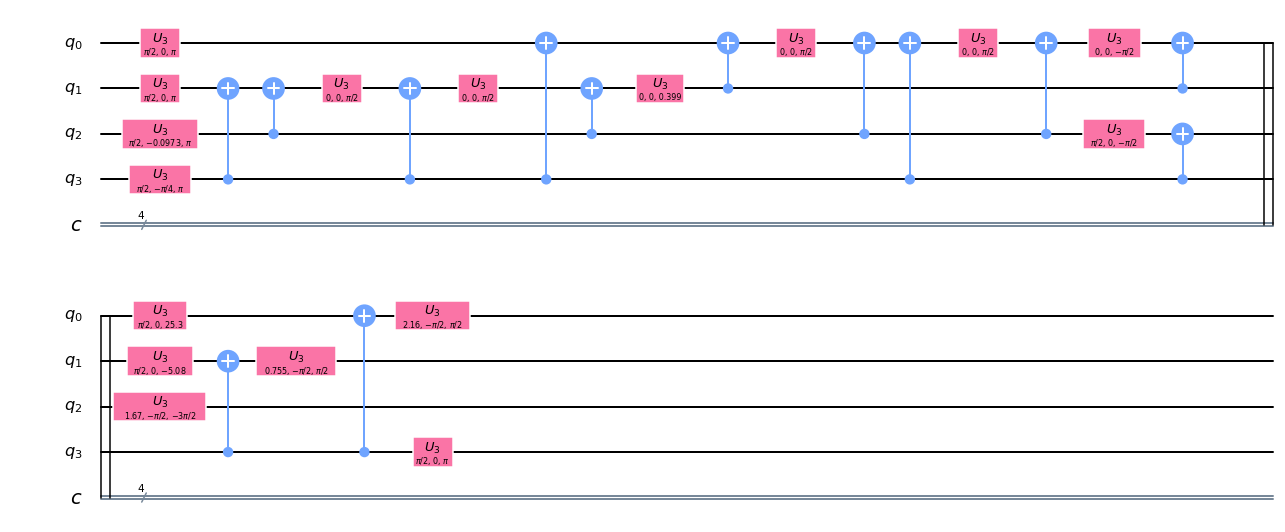

In [215]:
from qiskit import QuantumCircuit, transpile

qc = QuantumCircuit(4, 4)

qc.h([0,1,2,3])
qc.iso(H4*U*H4, [0, 1, 2, 3], [])
qc.h([0,1,2,3])

qc = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level = 2)
qc.draw()

In [216]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 9.942226695819332e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 147

Great! Your circuit meets all the constrains.
Your score is 147. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


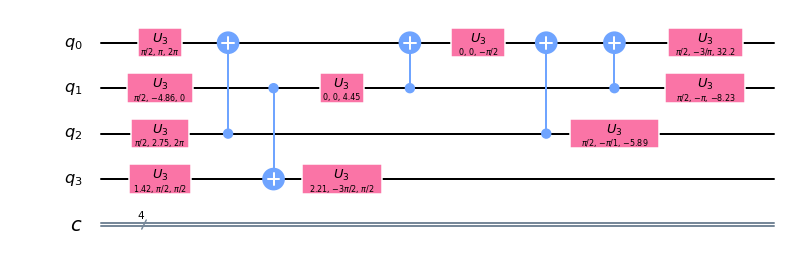

In [218]:
from qiskit import QuantumCircuit, transpile
from qiskit.extensions.standard.u3 import U3Gate

gate = U3Gate(np.pi/2, np.pi, 2*np.pi)
gate_inv = gate.inverse()

G = np.matrix(gate.to_matrix())
G2 = np.kron(G, G)
G4 = np.kron(G2, G2)

qc = QuantumCircuit(4, 4)

qc.append(gate, [0], [])
qc.append(gate, [1], [])
qc.append(gate, [2], [])
qc.append(gate, [3], [])
qc.iso(G4.H*U*G4, [0, 1, 2, 3], [])
qc.append(gate_inv, [0], [])
qc.append(gate_inv, [1], [])
qc.append(gate_inv, [2], [])
qc.append(gate_inv, [3], [])

qc = transpile(qc, basis_gates = ['cx', 'u3'], optimization_level = 2)
qc = transpile(qc, basis_gates = ['cx', 'u3'], optimization_level = 3)
qc.draw()

In [219]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.3043333429416315e-14
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 60

Great! Your circuit meets all the constrains.
Your score is 60. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


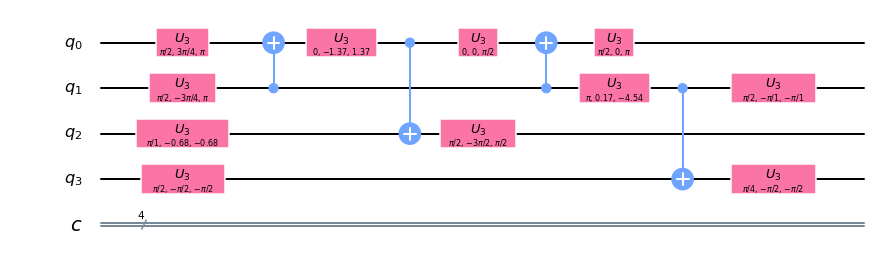

In [228]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator

qc = QuantumCircuit(4, 4)

qc.h([0, 1, 2, 3])
qc.rz(3*np.pi/4, 0)
qc.rz(5*np.pi/4, 1)
qc.rz(4*np.pi/4, 2)
qc.rz(1*np.pi/4, 3)

D = H4 * U * np.matrix(Operator(qc).data).H
for check_val in (0, 1, 1j, -1, -1j):
    D[np.isclose(D, check_val)] = check_val
    
qc.diagonal(list(np.diag(D)), [0, 1, 2, 3])
qc.h([0, 1, 2, 3])

qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=3)
qc.draw()

In [229]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 2.51225057164299e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 51

Great! Your circuit meets all the constrains.
Your score is 51. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [44]:
# Send the circuit as the final answer, can re-submit at any time
submit_circuit(qc) 